### Imports

In [1]:
import os
import sys
import random
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.optimizers import Adam
from keras.applications import vgg16
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.metrics import iou_score
from segmentation_models.losses import jaccard_loss

C:\Users\alessandra\Anaconda3\envs\PythonGPU1\lib\site-packages\classification_models\resnext\__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [4]:
from IPython.display import display
from PIL import Image
from pathlib import Path
import cv2
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

# Data generator

In [5]:
def norm_colors(x):
    x_norm = (x-x.min())/(x.max()-x.min())
    return x_norm

In [31]:
image_size = (256,256)
batch_size = 2

train_path = 'train_2018/'
valid_path = 'validation_2018/'

In [32]:
BACKBONE = 'inceptionresnetv2'
preprocess_input = get_preprocessing(BACKBONE)

## Training generator

In [33]:
seed=5
n=0

In [34]:
# we create two instances with the same arguments
data_gen_args_train = dict(featurewise_center=False, 
                     samplewise_center=False, 
                     featurewise_std_normalization=False, 
                     samplewise_std_normalization=False,
                     rescale=1./255,
                     #preprocessing_function=preprocess_input,
                     #rotation_range=10,
                     #width_shift_range=0.05,
                     #height_shift_range=0.05,
                     #zoom_range=[0.9,1.1],
                     #shear_range=0.3,
                     #channel_shift_range=0.005,
                     #brightness_range=[0.98,1.1],
                     #vertical_flip=True,
                     #horizontal_flip=True,
                     #validation_split=0.2
                     )
data_gen_args_mask_train = dict(#featurewise_center=False, 
                     samplewise_center=False, 
                     featurewise_std_normalization=False, 
                     samplewise_std_normalization=False,
                     rescale=1./255,
                     #rotation_range=10,
                     #width_shift_range=0.05,
                     #height_shift_range=0.05,
                     #zoom_range=[0.98,1.1],
                     #shear_range=0.3,
                     #channel_shift_range=0.005,
                     #brightness_range=[0.9,1.1],
                     #vertical_flip=True,
                     #horizontal_flip=True,
                     #validation_split=0.2
                     )
train_datagen = ImageDataGenerator(**data_gen_args_train)
mask_datagen = ImageDataGenerator(**data_gen_args_mask_train)

In [35]:
image_generator_train = train_datagen.flow_from_directory(
    'train_2018/images',  # this is the target directory
    target_size=image_size,
    color_mode = 'rgb',
    batch_size=batch_size,
    class_mode=None,
    #subset='training',
    #save_to_dir='train_2018/images/augmented',
    shuffle=False,
    seed = seed)

Found 1660 images belonging to 1 classes.


In [36]:
mask_generator_train = mask_datagen.flow_from_directory(
    'train_2018/masks/pigment_network',  # this is the target directory
    target_size=image_size,
    color_mode = 'grayscale',
    batch_size=batch_size,
    class_mode=None,
    #subset='training',
    #save_to_dir='train_2018/masks/augmented',
    shuffle=False,
    seed = seed)

Found 1660 images belonging to 1 classes.


In [95]:
maskB_generator_train = mask_datagen.flow_from_directory(
    'train_2018/masks_ben/',  # this is the target directory
    target_size=image_size,
    color_mode = 'grayscale',
    batch_size=batch_size,
    class_mode=None,
    #subset='training',
    #save_to_dir='train_2018/masks/augmented',
    shuffle=False,
    seed = seed)

Found 1660 images belonging to 1 classes.


In [37]:
train_generator = zip(image_generator_train, mask_generator_train)

## Visualization of images and masks

In [97]:
im_0 = image_generator_train[10][n] # [number of the batch: 0-414][number of the image in the batch: 0-3]
mask_0=mask_generator_train[10][n]
maskB_0=maskB_generator_train[10][n]

In [39]:
image_generator_train[2].shape

(2, 256, 256, 3)

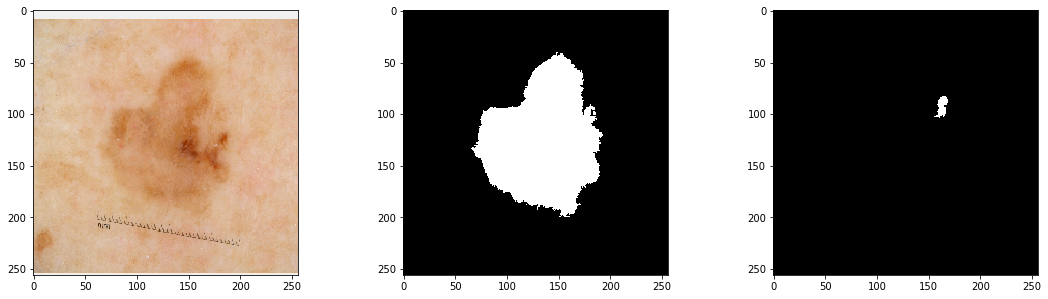

In [98]:
fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(norm_colors(im_0))

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(maskB_0, image_size), cmap="gray")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(np.reshape(mask_0, image_size), cmap="gray")


## Validation generator (no augmentation)

In [41]:
# we create two instances with the same arguments
data_gen_args_val = dict(featurewise_center=False, 
                     samplewise_center=False, 
                     featurewise_std_normalization=False, 
                     samplewise_std_normalization=False,
                     rescale=1./255
                     #preprocessing_function=preprocess_input,
                     #validation_split=0.2
                     )
data_gen_args_mask_val = dict(featurewise_center=False, 
                     samplewise_center=False, 
                     featurewise_std_normalization=False, 
                     samplewise_std_normalization=False,
                     rescale=1./255,
                     #validation_split=0.2
                     )

In [42]:
val_datagen = ImageDataGenerator(**data_gen_args_val)
mask_datagen_val = ImageDataGenerator(**data_gen_args_mask_val)

In [43]:
image_generator_val = val_datagen.flow_from_directory(
    'validation_2018/images',
    target_size=image_size,
    color_mode = 'rgb',
    batch_size=1,
    class_mode=None,
    seed=1,
    shuffle=False)
    #subset='validation') # set as validation data

Found 414 images belonging to 1 classes.


In [44]:
mask_generator_val = mask_datagen_val.flow_from_directory(
    'validation_2018/masks/pigment_network',  # this is the target directory
    target_size=image_size,
    color_mode = 'grayscale',
    batch_size=1,
    class_mode=None,
    seed=1,
    shuffle=False)
    #subset='validation')

Found 414 images belonging to 1 classes.


In [99]:
maskB_generator_val = mask_datagen.flow_from_directory(
    'validation_2018/masks_ben/',  # this is the target directory
    target_size=image_size,
    color_mode = 'grayscale',
    batch_size=1,
    class_mode=None,
    #subset='training',
    #save_to_dir='train_2018/masks/augmented',
    shuffle=False,
    seed = seed)

Found 414 images belonging to 1 classes.


In [45]:
val_generator = zip(image_generator_val, mask_generator_val)

# Unet

In [24]:
model = Unet(backbone_name='inceptionresnetv2', input_shape=(None, None, 3), classes=1, activation='sigmoid', 
             encoder_weights='imagenet', encoder_freeze=False, encoder_features='default', decoder_block_type='upsampling',
             decoder_filters=(256, 128, 64, 32, 16), decoder_use_batchnorm=True)

Instructions for updating:
Colocations handled automatically by placer.


In [46]:
from keras.losses import binary_crossentropy
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = K.sum(intersection) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) -K.sum(y_true_f*y_pred_f)+ smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return (binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred))/2.

In [187]:
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
iou_score = segmentation_models.metrics.iou_score(gt, pr, class_weights=1.0, smooth=1.0, per_image=True, threshold=None)

In [188]:
model.compile(metrics =[iou_score], loss = bce_dice_loss, optimizer=adam)

0: indicating areas where the dermoscopic attribute is absent
255: indicating areas where the the dermoscopic attribute is present -> 1

## Fit the model with no augmentation on data starting from Task1 weights

In [ ]:
load_name = ''.join([model_name, str(start_epoch),".hd5"])
model.load_weights(load_name)

In [49]:
#Load partly trained model
model.load_weights('model-Unet_Alex.h5')

In [50]:
save_model_path ="tmp/Unet1-{epoch:02d}-{val_loss:.2f}.hdf5"
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(filepath=save_model_path, monitor='val_loss', save_best_only=True, verbose=1)
]

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = image_generator_train.samples // batch_size,
    validation_data = val_generator, 
    validation_steps = image_generator_val.samples,
    epochs=6,
    verbose=1,
    callbacks=callbacks)

In [189]:
## Save the Weights
model_path = "tmp/Unet-06-0.51.hdf5"
model.load_weights(model_path)

In [240]:
#show 22 - 25 -30 - 60 cut at 0.5 - 350 -360
view_id = 310
x, y , z= image_generator_val[view_id], mask_generator_val[view_id], maskB_generator_val[view_id]
    
result = model.predict(x)
#result = result > 0.5

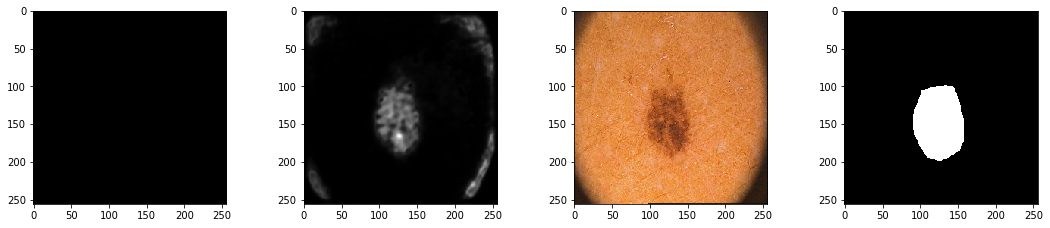

In [241]:
fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 4, 1)
ax.imshow(np.reshape(y[0]*255, image_size), cmap="gray")

ax = fig.add_subplot(1, 4, 2)
ax.imshow(np.reshape(result[0]*255, image_size), cmap="gray")

ax = fig.add_subplot(1, 4, 3)
ax.imshow(norm_colors(x[0]))

ax = fig.add_subplot(1, 4, 4)
ax.imshow(np.reshape(z[0]*255, image_size), cmap="gray")

In [ ]:
def train_and_save(max_epoch, model_name, train_path, image_size, start_epoch = 0, test_split = 100, batchsize = 10):
    ## Training Ids   
   
    if start_epoch != 0:
        load_name = ''.join([model_name, str(start_epoch),".hd5"])
        model.load_weights(load_name)
      
    for i in np.arange(start_epoch,max_epoch):
        print("Epoch %i/%i" %((i+1),max_epoch))
        save_name = ''.join([model_name,str(i+1),".hd5"])
        model.fit_generator(train_gen, validation_data=test_gen,steps_per_epoch=train_steps,  epochs=1)
        model.save_weights(save_name)

In [39]:
def load_model_and_predict(max_epoch,test_gen):
    for j in range(max_epoch):
        model = UNet()
        model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])
        model_path = os.path.join("UNet_2018_256_ep_" + str(j + 1) + ".hd5")
        model.load_weights(model_path)
        
        for i in range(len(test_gen)):
            # predict the mask for each picture
            x, y = test_gen.__getitem__(i)
            result = model.predict(x)
            result = result > 0.5
            result = result[0].astype('uint8').reshape(256,256)
            fig,ax = plt.subplots(figsize=(8,6))
            ax.imshow(result, cmap="gray")
            ax.text(20,20,str(j + 1),color='red',fontsize=16)
            fig.savefig(os.path.join("pred_Unet/pred_" + str(i) + "_epoch_" + str(j + 1).zfill(2) + ".png"))
            plt.close()
            if j == 0:
                plt.imsave(os.path.join("pred_Unet/mask_" + str(i) +".png"),y[0].astype('uint8').reshape(256,256), cmap='gray')

In [40]:
load_model_and_predict(2,test_gen)

In [ ]:
def train_and_save(max_epoch, model_name, train_path, image_size, start_epoch = 0, test_split = 100, batchsize = 10):
    ## Training Ids
    train_ids = next(os.walk("train_2018/images/"))[2]
    train_ids = [os.path.splitext(x)[0] for x in train_ids]
    
    test_ids = train_ids[:val_data_size]
    train_ids = train_ids[val_data_size:]
    
    model = UNet()
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["binary_crossentropy"])
    
    if start_epoch != 0:
        load_name = ''.join([model_name, str(start_epoch),".hd5"])
        model.load_weights(load_name)
    
    train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
    test_gen = DataGen(test_ids, train_path, image_size=image_size, batch_size=1)
    
    train_steps = len(train_ids)//batch_size
    test_steps = len(test_ids)//batch_size

    for i in np.arange(start_epoch,max_epoch):
        print("Epoch %i/%i" %((i+1),max_epoch))
        save_name = ''.join([model_name,str(i+1),".hd5"])
        model.fit_generator(train_gen, validation_data=test_gen,steps_per_epoch=train_steps,  epochs=1)
        model.save_weights(save_name)

In [ ]:
train_and_save(41,"UNet_2018_256_ep_","train_2018/",256,start_epoch=40)

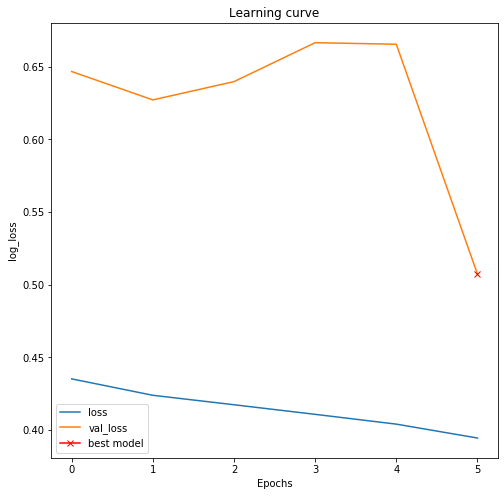

In [88]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();